<a href="https://colab.research.google.com/github/puja431996/Notebook/blob/master/Multi_Class_MobileNet(4_Class).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Libraries

---



In [1]:
# import keras
import tensorflow as tf
from zipfile import ZipFile
from matplotlib import pyplot as plt
import cv2
import os
import seaborn as sn
import numpy as np
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
import keras
import keras.backend as K
from keras.models import Sequential
from tensorflow.keras.models import load_model
from keras import layers 
#from keras.applications import VGG16 
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.applications.mobilenet import MobileNet
from keras.optimizers import SGD,Adam,RMSprop
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [2]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

###Mount Drive

---



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!cd drive && cd 'My Drive' && cd COVID_19 && cd copy_folder && cd covid19-detection-xray-dataset && ls

NonAugmentedTrain  TrainData  ValData


#Image Preprocessing

---



###ImageDataGenerator

---



In [5]:
img_height = 224
img_width = 224
batch_size = 32

train_data_dir = "/content/drive/My Drive/COVID_19/covid19-detection-xray-dataset/"
test_data_dir = "/content/drive/My Drive/COVID_19/copy_folder/covid19-detection-xray-dataset/"
train_datagen = ImageDataGenerator( rescale = 1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir+"TrainData/",
        target_size=(img_height, img_width),
        batch_size=32,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        test_data_dir+"ValData/",
        target_size=(img_height, img_width),
        batch_size=32,
        class_mode='categorical',
        shuffle = False)

Found 2023 images belonging to 4 classes.
Found 1257 images belonging to 4 classes.


In [26]:
train_generator.class_indices

{'BacterialPneumonia': 0, 'COVID-19': 1, 'Normal': 2, 'ViralPneumonia': 3}

#Built Model

---



###Load Model

---



In [0]:
loaded_model = load_model("/content/drive/My Drive/saved_models/mobilenetv2_finetuned.h5")

In [7]:
loaded_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,863,873
Non-trainable params: 395,392
_________________________________________________________________


In [8]:
loaded_model.layers[-2].output

<tf.Tensor 'global_average_pooling2d_2/Identity:0' shape=(None, 1280) dtype=float32>

###Remove last layer

---



In [0]:
from tensorflow.keras.models import Model
loaded_model.layers.pop()
loaded_model.layers.pop()
top_model = Model(loaded_model.input,loaded_model.layers[-2].output)

In [10]:
top_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224_input ( [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
Total params: 2,257,984
Trainable params: 1,862,592
Non-trainable params: 395,392
_________________________________________________________________


In [0]:
top_model.trainable = False

In [0]:
hidden_layer = tf.keras.layers.Dense(64,activation="relu")
dropout_layer = tf.keras.layers.Dropout(0.5)
prediction_layer = tf.keras.layers.Dense(4,activation="softmax")

###Transfer learning using model trained on Mendleye data with binary classification

---



In [0]:
model = tf.keras.Sequential([
  top_model,
  hidden_layer,
  dropout_layer,
  prediction_layer
])

###Final model summary

---



In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 64)                81984     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 260       
Total params: 2,340,228
Trainable params: 82,244
Non-trainable params: 2,257,984
_________________________________________________________________


###Model Compiling

---



In [0]:
base_learning_rate = 0.0001
model.compile(loss = 'categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.0001, decay=0.0),metrics=['accuracy'])

###Use EarlyStop and Csv Logger

---



In [0]:
from tensorflow.keras.callbacks import CSVLogger,EarlyStopping
csv_logger = CSVLogger('Multi_Class_MobileNet.csv', append=False, separator=';')
#ES = EarlyStopping(monitor='val_accuracy', patience=3)

###Fit model

---



In [17]:

history = model.fit(train_generator,steps_per_epoch=64,epochs = 15,validation_data=validation_generator,validation_steps= 40,callbacks=[csv_logger],verbose=1)

Epoch 1/15
64/64 [==============================] - 1369s 21s/step - loss: 1.2718 - accuracy: 0.4271 - val_loss: 1.2960 - val_accuracy: 0.4837
Epoch 2/15
64/64 [==============================] - 44s 682ms/step - loss: 0.9999 - accuracy: 0.5868 - val_loss: 1.0771 - val_accuracy: 0.5505
Epoch 3/15
64/64 [==============================] - 44s 692ms/step - loss: 0.8784 - accuracy: 0.6362 - val_loss: 0.9476 - val_accuracy: 0.6094
Epoch 4/15
64/64 [==============================] - 46s 716ms/step - loss: 0.7814 - accuracy: 0.6826 - val_loss: 0.8290 - val_accuracy: 0.6937
Epoch 5/15
64/64 [==============================] - 47s 729ms/step - loss: 0.7388 - accuracy: 0.6886 - val_loss: 0.7665 - val_accuracy: 0.7232
Epoch 6/15
64/64 [==============================] - 46s 723ms/step - loss: 0.6811 - accuracy: 0.7163 - val_loss: 0.7382 - val_accuracy: 0.7319
Epoch 7/15
64/64 [==============================] - 47s 736ms/step - loss: 0.6720 - accuracy: 0.7232 - val_loss: 0.7033 - val_accuracy: 0.7494

#Outputs

---



###Accuracy and Loss Plot

---



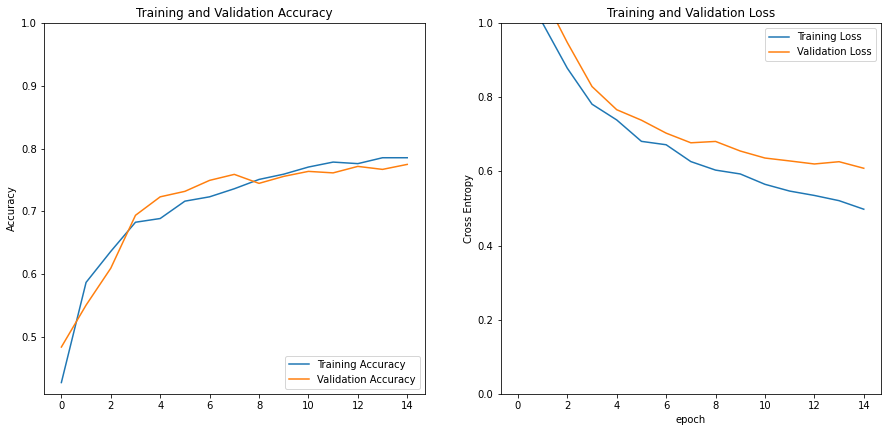

In [18]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

###Confusion Matrix

---



In [19]:
import seaborn as sn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
validation_generator.reset()
Y_preds=model.predict_generator(validation_generator,40)
y_pred = np.argmax(Y_preds, axis=1)
Matrix = confusion_matrix(validation_generator.classes, y_pred)
print('Confusion Matrix')
print(Matrix)
print('Classification Report')
target_names = ['BN', 'COVID-19', 'Normal', 'VN']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Instructions for updating:
Please use Model.predict, which supports generators.
Confusion Matrix
[[242   4  64  14]
 [ 29 239  10   0]
 [  2   0 448   0]
 [ 89   5  66  45]]
Classification Report
              precision    recall  f1-score   support

          BN       0.67      0.75      0.71       324
    COVID-19       0.96      0.86      0.91       278
      Normal       0.76      1.00      0.86       450
          VN       0.76      0.22      0.34       205

    accuracy                           0.77      1257
   macro avg       0.79      0.71      0.70      1257
weighted avg       0.78      0.77      0.75      1257



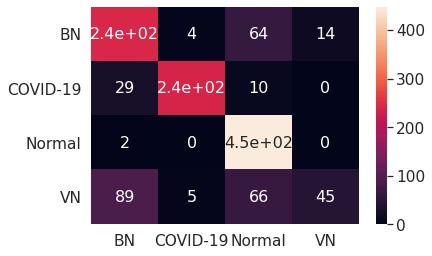

In [20]:
df_cm = pd.DataFrame(Matrix, target_names, target_names)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()

###Test Images

---



In [0]:
model.save("/content/drive/My Drive/saved_models/Multi_Class_Covid_MobileNetV2_4class.h5")

In [22]:
score = model.evaluate_generator(validation_generator,steps=40)

Instructions for updating:
Please use Model.evaluate, which supports generators.


In [23]:
score[1]

0.7748607993125916

In [0]:
from google.colab import files
files.download('Multi_Class_MobileNet.csv')